In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pandas as pd
import scipy
import csv

from poisson_process import NHPoissonProcess
from mcmc import PoissonMCMC
from visualisation import plot_trace, plot_densities, plot_autocorr, plot_ess
from parameters.params import Params
from densities import gpd_quantile


In [2]:
from IPython.display import display


# Parameters loading


In [3]:
poisson_params_directory = "parameters/poisson_simu/"

# poisson_config = "sharkey_poisson_config"
# poisson_config = "tony_poisson_config"
poisson_config = "negative_xi_config"

poisson_params = Params(poisson_params_directory + poisson_config + ".json")

mcmc_params_directory = "parameters/mcmc/"
# mcmc_configs = ["Config3.json", "Config4.json", "Config5.json"]
mcmc_configs = ["Config4.json"]

# mcmc_configs = []
# for filename in os.listdir(mcmc_params_directory):
#     if "json" in filename:
#         mcmc_configs.append(filename)

estimator = "mode"


# Data simulation

Poisson process parameter: (mu = 50, sigma = 15, xi = -0.25)
Orthogonal version: (r = 126.42, nu = 15.00, xi = -0.25)
Expected number of points: 126.42
Number of generated points: 132
Min: 30.275
Max: 83.382

Estimation of quantiles 1/126, 1/252 and 1/379 
Theoretical values of quantiles: 86.142, 89.938, 91.872


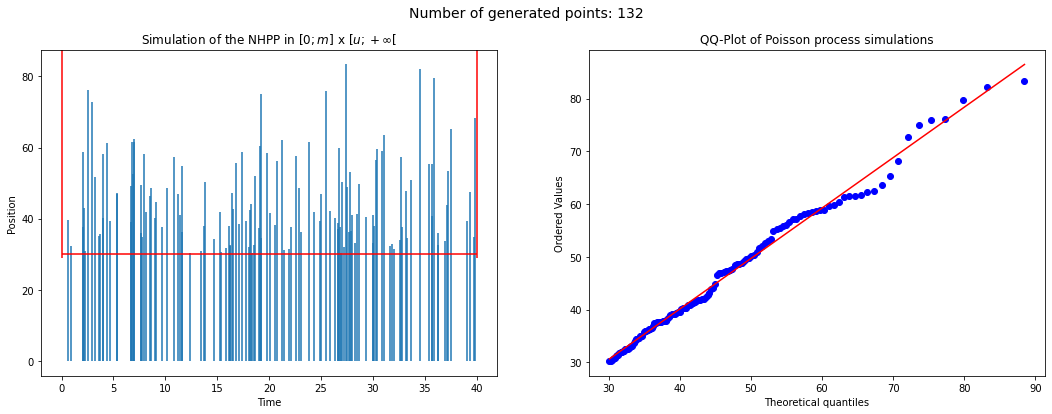

In [4]:
PP = NHPoissonProcess(mu=poisson_params.mu, sig=poisson_params.sigma, xi=poisson_params.xi,
                      u=poisson_params.u, m=poisson_params.m)

lam_obs = PP.get_measure()
n_obs = PP.gen_number_points()[0]

obs = PP.gen_positions(n_obs=n_obs)
times = PP.gen_time_events(n_obs=n_obs)

pp_params = PP.get_parameters()
print("Poisson process parameter: (mu = {}, sigma = {}, xi = {})".format(pp_params[2],
                                                                         pp_params[3],
                                                                         pp_params[4]))
ortho_params = PP.get_orthogonal_reparam()
print("Orthogonal version: (r = {:.2f}, nu = {:.2f}, xi = {})".format(ortho_params[0],
                                                                      ortho_params[1],
                                                                      ortho_params[2]))
print("Expected number of points: {:.2f}".format(lam_obs))
print("Number of generated points:", n_obs)
print("Min: {:.3f}".format(np.min(obs)))
print("Max: {:.3f}".format(np.max(obs)))

quantiles = (1/lam_obs, 1/(2*lam_obs), 1/(3*lam_obs))
print("\nEstimation of quantiles 1/{}, 1/{} and 1/{} ".format(int(lam_obs), int(2*lam_obs), int(3*lam_obs)))
sig_tilde = pp_params[3]+pp_params[4]*(pp_params[0]-pp_params[2])
real_q1 = gpd_quantile(prob=quantiles[0], mu=pp_params[0], sig=sig_tilde, xi=pp_params[4])
real_q2 = gpd_quantile(prob=quantiles[1], mu=pp_params[0], sig=sig_tilde, xi=pp_params[4])
real_q3 = gpd_quantile(prob=quantiles[2], mu=pp_params[0], sig=sig_tilde, xi=pp_params[4])
print("Theoretical values of quantiles: {:.3f}, {:.3f}, {:.3f}".format(real_q1, real_q2, real_q3))

PP.plot_simulation(times=times, positions=obs)


# MCMC


Config file:  Config4.json
Flat Prior on orthogonal parameters

Choice of m = 40 for MCMC

 Summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,mode
mu_m,50.703,2.055,46.845,54.544,0.058,0.041,1245.0,1245.0,1238.0,1605.0,1.00,51.212
sig_m,14.515,0.953,12.832,16.359,0.030,0.021,1023.0,1023.0,1021.0,1408.0,1.01,14.091
xi,-0.291,0.082,-0.434,-0.129,0.003,0.002,882.0,882.0,902.0,987.0,1.01,-0.361


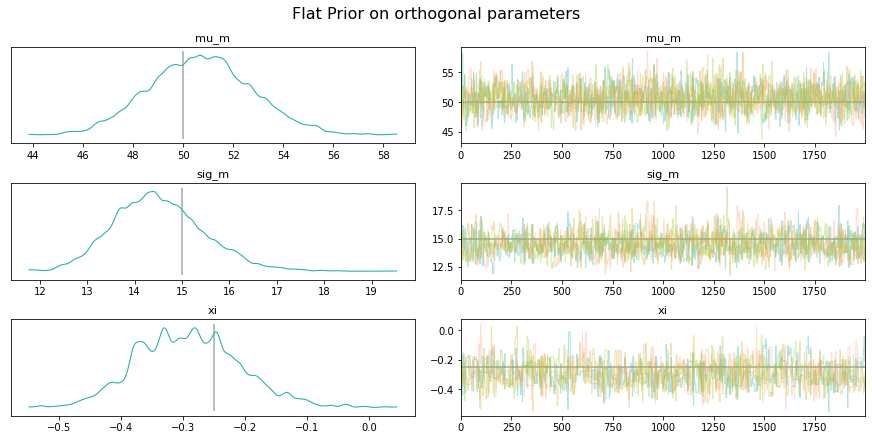


 Quantiles Summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,mode
q1r,83.708,4.871,76.693,92.862,0.182,0.129,717.0,717.0,750.0,928.0,1.01,80.842
q2r,87.042,5.973,78.823,98.112,0.223,0.158,716.0,716.0,750.0,908.0,1.01,83.454
q3r,88.730,6.637,79.911,100.978,0.248,0.175,717.0,717.0,754.0,880.0,1.01,84.724


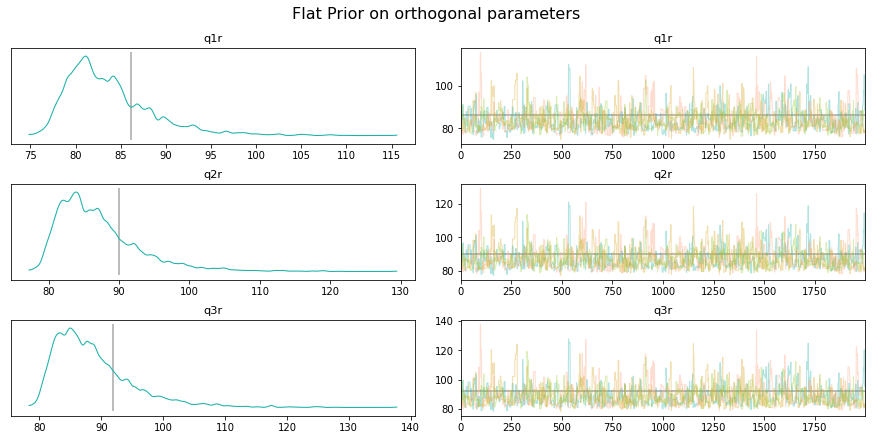

In [5]:
traces = []
traces_orthogonal = []
names = []
names_orthogonal = []

func_dict = {"mode": lambda x: scipy.stats.mode(x, axis=None).mode[0]}


for filename in mcmc_configs:
    print("\nConfig file: ", filename)
    mcmc_params = Params(mcmc_params_directory + filename)
    print(mcmc_params.name)
    print("")
    
    priors = [mcmc_params.priors["p1"],
              mcmc_params.priors["p2"],
              mcmc_params.priors["p3"]]

    if mcmc_params.init_p1_by_u:
        init_val = n_obs if mcmc_params.orthogonal_param else poisson_params.u
        priors[0] = priors[0].replace("u", str(init_val))

    MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter,
                       obs=obs, u=poisson_params.u, m=poisson_params.m, quantiles=quantiles,
                       orthogonal_param=mcmc_params.orthogonal_param)
    if mcmc_params.update_m != "":
        MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)
    print("Choice of m = {} for MCMC".format(MCMC.m))

    trace = MCMC.run(verbose=False)

    names.append(mcmc_params.name)
    traces.append(trace)
    
    print("\n Summary:")
    display(az.summary(data=trace, stat_funcs=func_dict, var_names=["mu_m", "sig_m", "xi"]))
    plot_trace(trace, var_names=["mu_m", "sig_m", "xi"], title=mcmc_params.name, real_value=pp_params[2:5])
    plt.show()

    
    print("\n Quantiles Summary:")
    display(az.summary(data=trace, stat_funcs=func_dict, var_names=["q1r", "q2r", "q3r"]))
    plot_trace(trace, var_names=["q1r", "q2r", "q3r"], title=mcmc_params.name, real_value=[real_q1, real_q2, real_q3])
    plt.show()


    # if MCMC.orthogonal_param:
    #     plot_trace(trace, var_names=["r", "nu", "xi"], title=mcmc_params.name)
    #     names_orthogonal.append(mcmc_params.name)
    #     traces_orthogonal.append(trace)
    

## Autocorrelations and ESS on parameters :

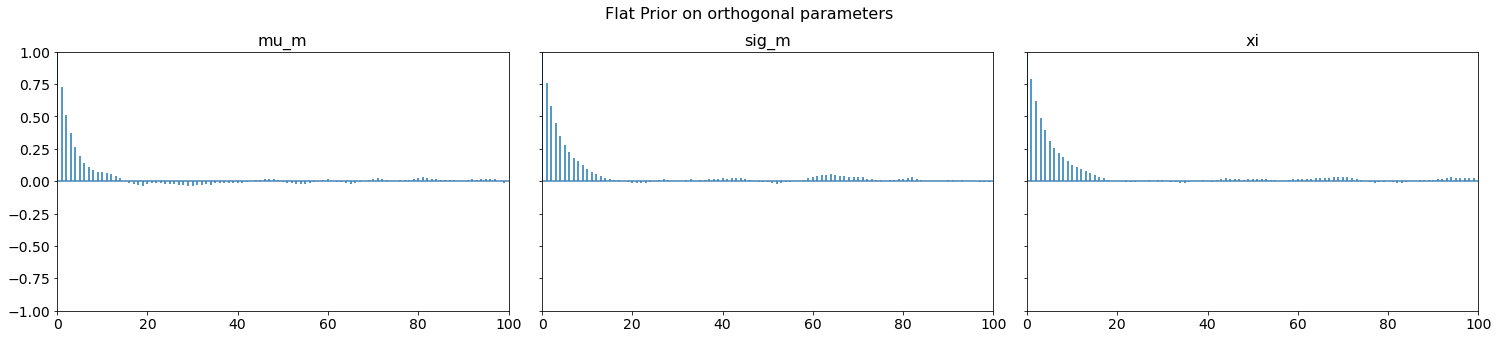

In [6]:
plot_autocorr(traces=traces, labels=names, var_names=["mu_m", "sig_m", "xi"])
plt.show()

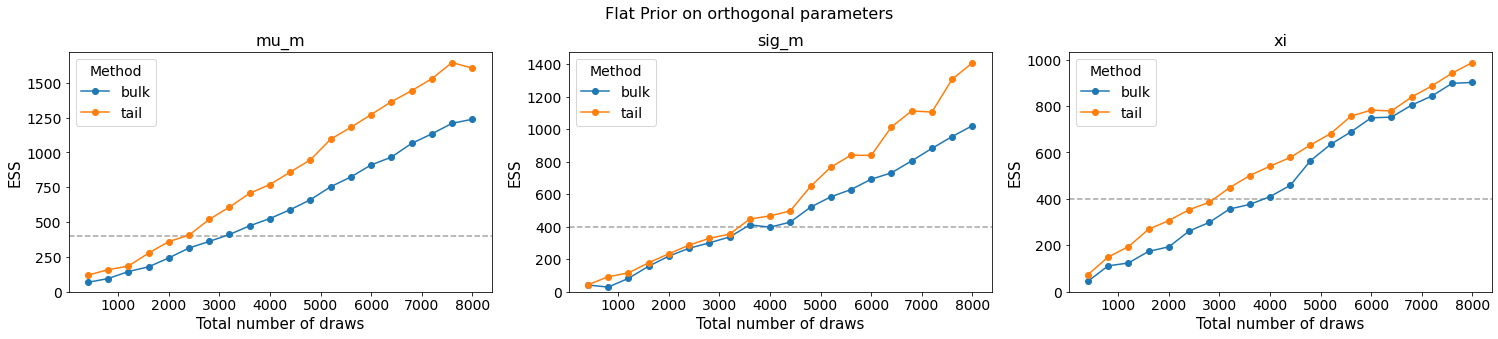

In [7]:
plot_ess(traces=traces, labels=names, var_names=["mu_m", "sig_m", "xi"])
plt.show()

## Autocorrelations and ESS on quantile estimation

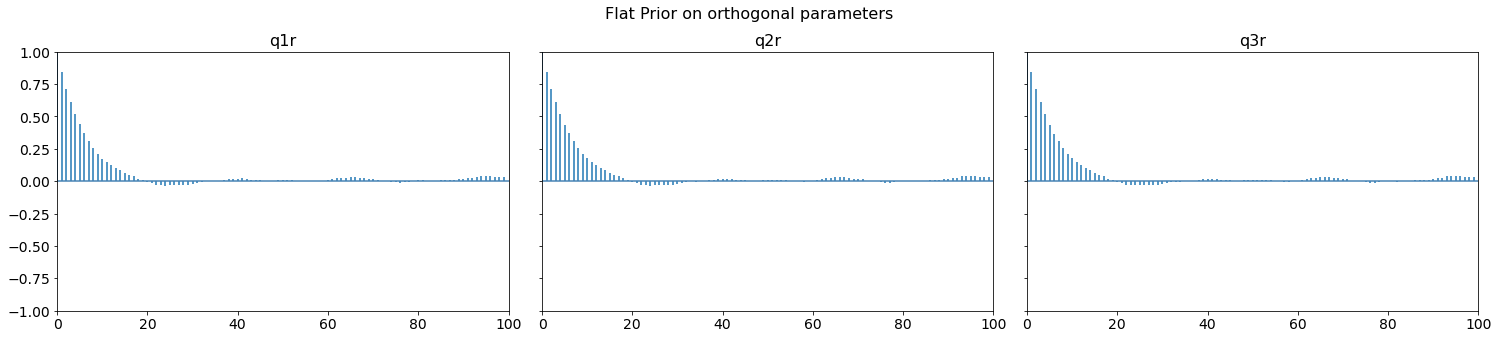

In [8]:
plot_autocorr(traces=traces, labels=names, var_names=["q1r", "q2r", "q3r"])
plt.show()

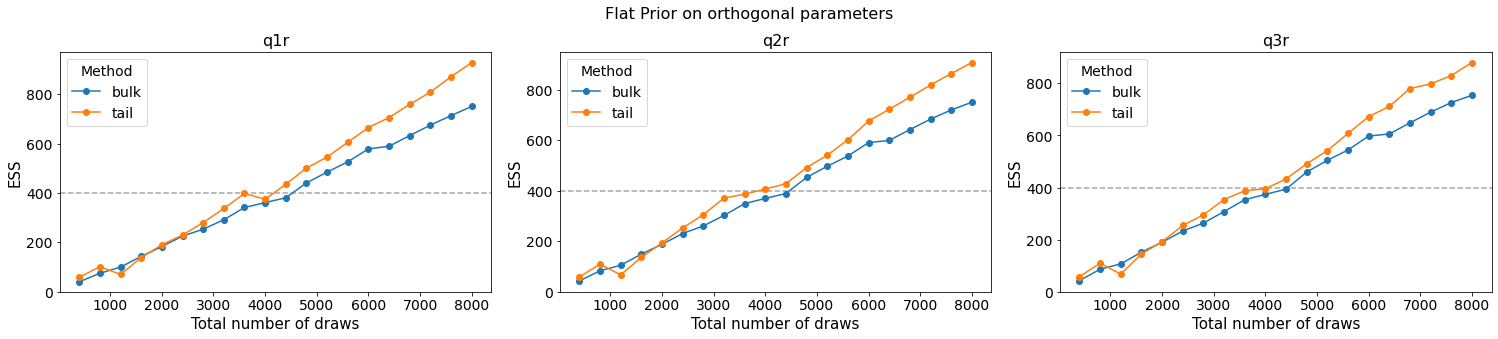

In [9]:
plot_ess(traces=traces, labels=names, var_names=["q1r", "q2r", "q3r"])
plt.show()

In [59]:
trace.posterior["xi"]

<xarray.DataArray 'xi' (chain: 4, draw: 2000)>
array([[-0.22650452, -0.22650452, -0.22650452, ..., -0.20685245,
        -0.20685245, -0.20685245],
       [-0.38230183, -0.38230183, -0.38230183, ..., -0.34426138,
        -0.34426138, -0.27240755],
       [-0.34048693, -0.24527984, -0.24527984, ..., -0.40942322,
        -0.40942322, -0.40942322],
       [-0.2470359 , -0.2470359 , -0.2470359 , ..., -0.38220185,
        -0.30688896, -0.30688896]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999

In [21]:
az.summary(data=trace, var_names=["r", "nu", "xi"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
r,132.260,11.354,112.815,154.940,0.310,0.220,1342.0,1338.0,1347.0,1325.0,1.00
nu,14.456,0.908,12.940,16.190,0.031,0.022,831.0,828.0,848.0,885.0,1.01
xi,-0.291,0.082,-0.434,-0.129,0.003,0.002,882.0,882.0,902.0,987.0,1.01


In [167]:
localrhat_summary(data=trace, var_names=["r", "nu", "xi"])


Multivariate R-hat-infinity on all dependence directions: 1.010 (threshold: 1.043)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,r_threshold,r_hat_inf
r,132.260,11.354,112.815,154.940,0.310,0.220,1342.0,1338.0,1347.0,1325.0,1.00,1.031,1.007
nu,14.456,0.908,12.940,16.190,0.031,0.022,831.0,828.0,848.0,885.0,1.01,1.031,1.011
xi,-0.291,0.082,-0.434,-0.129,0.003,0.002,882.0,882.0,902.0,987.0,1.01,1.031,1.007


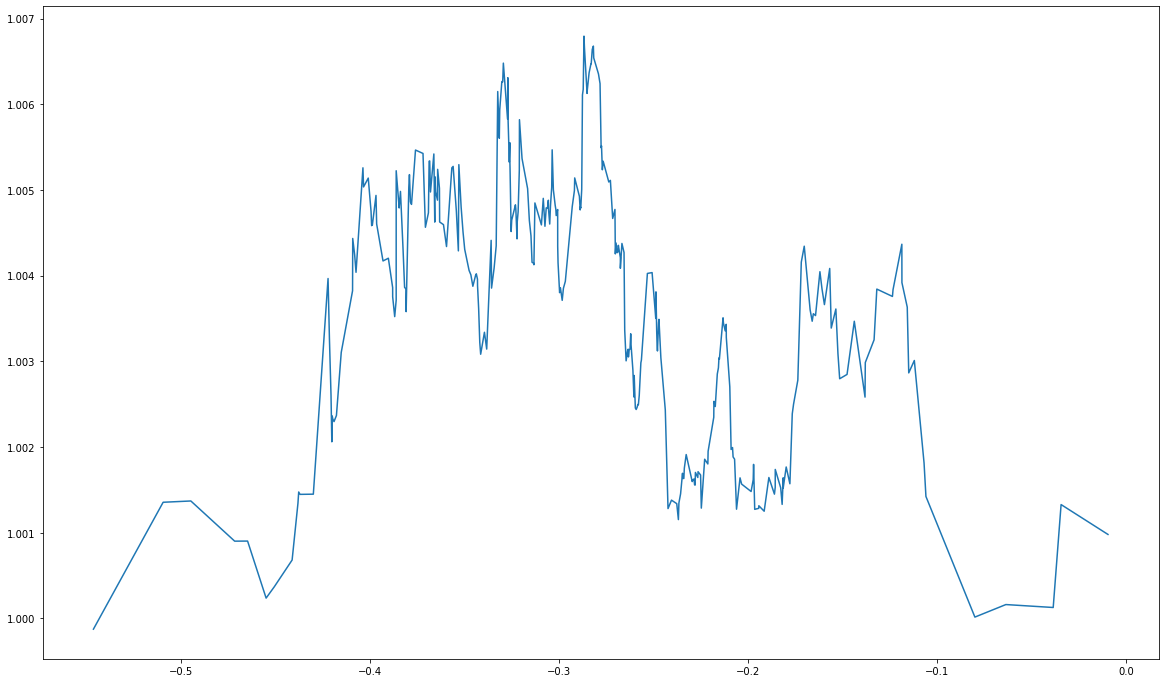

In [112]:
# xi_chains = np.asarray(traces[0].posterior["xi"]).transpose(1,0)
grid, r_val = r_x_values(xi_chains)

plt.figure(figsize = (20,12))
plt.plot(grid, r_val)
plt.show()

In [121]:
traces[0].posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 2000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    xi       (chain, draw) float64 -0.2265 -0.2265 -0.2265 ... -0.3069 -0.3069
    r        (chain, draw) float64 141.4 142.4 152.3 152.3 ... 113.6 113.6 134.2
    nu       (chain, draw) float64 13.6 15.26 15.26 15.26 ... 13.58 13.58 13.58
    mu_m     (chain, draw) float64 49.31 51.76 52.76 52.76 ... 48.92 47.5 49.82
    sig_m    (chain, draw) float64 13.21 14.8 14.57 14.57 ... 14.75 14.23 13.51
    q1r      (chain, draw) float64 81.68 87.99 87.99 87.99 ... 78.47 79.39 79.39
    q2r      (chain, draw) float64 85.44 92.22 92.22 92.22 ... 80.58 82.16 82.16
    q3r      (chain, draw) float64 87.39 94.41 94.41 94.41 ... 81.58 83.53 83.53
Attributes:
    created_at:                 2022-03-08T15:36:33.888083
    arviz_version:              0.11.0
    inference_library:          pymc3
    inference_library_version:  3.10.0
    sampling_time:              2.2594525814056396
    tuning_steps:               1000

In [136]:
mu_chains = np.asarray(traces[0].posterior["r"]).transpose(1,0)
sig_chains = np.asarray(traces[0].posterior["nu"]).transpose(1,0)
xi_chains = np.asarray(traces[0].posterior["xi"]).transpose(1,0)

mul_chains = np.asarray([mu_chains, sig_chains, xi_chains]).transpose(1,0,2)
# mul_chains.shape

rhat_infinity_max_directions(mul_chains)

# multivariate_all_local_rhat(mul_chains, max_nb_points = 500)

1.0087470685358895

In [17]:
break

SyntaxError: 'break' outside loop (<ipython-input-17-6aaf1f276005>, line 4)

# Repeated simulations

In [ ]:
print("Poisson process parameter: (mu = {}, sigma = {}, xi = {})".format(pp_params[2],
                                                                         pp_params[3],
                                                                         pp_params[4]))

print("Real values of quantiles: {:.3f}, {:.3f}, {:.3f}".format(real_q1, real_q2, real_q3))


verbose = False

nb_repetitions = 100

all_summaries = []
all_summaries_quantile = []

for idx_config, filename in enumerate(mcmc_configs):
    print("\n##### Config file: {} #####".format(filename))
    mcmc_params = Params(mcmc_params_directory + filename)
    print(mcmc_params.name)

    priors = [mcmc_params.priors["p1"],
              mcmc_params.priors["p2"],
              mcmc_params.priors["p3"]]

    if mcmc_params.init_p1_by_u:
        init_val = n_obs if mcmc_params.orthogonal_param else poisson_params.u
        priors[0] = priors[0].replace("u", str(init_val))

    summaries = []
    summaries_quantile = []
    for i in range(nb_repetitions):
        
        PP = NHPoissonProcess(mu=poisson_params.mu, sig=poisson_params.sigma, xi=poisson_params.xi,
                      u=poisson_params.u, m=poisson_params.m)

        n_obs = PP.gen_number_points()[0]
        obs = PP.gen_positions(n_obs=n_obs)
        
        if verbose:
            print("\nSimulation {}:".format(i+1))
            print("    Number of generated points:", n_obs)
        else:
            print("\r     Simulation {}/{}".format(i+1,nb_repetitions), end="")

        pp_params = PP.get_parameters()
        
        MCMC = PoissonMCMC(priors=priors, step_method=mcmc_params.step_method, niter=mcmc_params.niter, quantiles=quantiles,
                           obs=obs, u=poisson_params.u, m=poisson_params.m, orthogonal_param=mcmc_params.orthogonal_param)
        
        if mcmc_params.update_m != "":
            MCMC.update_m(update_arg=mcmc_params.update_m, xi=poisson_params.xi)
        
        trace = MCMC.run(verbose=False)

        df = az.summary(data=trace, stat_funcs=func_dict, var_names=["mu_m", "sig_m", "xi"])
        df["group"] = ["mu","sig","xi"]
        summaries.append(df)
        
        if verbose:
            print("    Choice of m = {} for MCMC".format(MCMC.m))
            print("\n Summary:")

            display(summaries[i])
            plot_trace(trace, var_names=["mu_m", "sig_m", "xi"], title=mcmc_params.name, real_value=pp_params[2:5])
            plt.show()
        
        
        df_q = az.summary(data=trace, stat_funcs=func_dict, var_names=["q1r", "q2r", "q3r"])
        df_q["group"] = ["q1","q2","q3"]
        summaries_quantile.append(df_q)
    
    summaries_df = pd.concat(summaries, ignore_index=True)
    summaries_df["config"] = "Config. "+str(idx_config+1)
    all_summaries.append(summaries_df)
    
    summaries_quantile_df = pd.concat(summaries_quantile, ignore_index=True)
    summaries_quantile_df["config"] = "Config. "+str(idx_config+1)
    all_summaries_quantile.append(summaries_quantile_df)
    
    print("\n\n")
    print('Mean of summaries:')
    display(summaries_df.groupby('group').mean())
    var = list(summaries_df.groupby('group').var()[estimator])
    print('Variance of posterior means: {:.3f}, {:.3f}, {:.3f}'.format(var[0], var[1], var[2]))

    print('\nMean of summaries for quantiles:')
    display(summaries_quantile_df.groupby('group').mean())
    var_q = list(summaries_quantile_df.groupby('group').var()[estimator])
    print('Variance of posterior means for quantiles: {:.3f}, {:.3f}, {:.3f}'.format(var_q[0], var_q[1], var_q[2]))

all_summaries_df = pd.concat(all_summaries, ignore_index=True)
all_summaries_quantile_df = pd.concat(all_summaries_quantile, ignore_index=True)

In [ ]:
all_summaries_df[all_summaries_df["group"] == "mu"]

In [ ]:


fig, axes = plt.subplots(1, 3, figsize=(20,10))

ax = sns.boxplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "mu"], width=0.5, ax=axes.flatten()[0])
# ax.set_ylim(mu_means.min()*0.99, mu_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(pp_params[2], ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "mu"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[0])
ax.set_ylabel("Posterior Means", fontsize=18)
ax.set_xlabel("$\mu$", fontsize=20)



ax = sns.boxplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "sig"], width=0.5, ax=axes.flatten()[1])
# ax.set_ylim(sig_means.min()*0.99, sig_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(pp_params[3], ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "sig"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[1])
ax.set_ylabel("", fontsize=15)
ax.set_xlabel("$\sigma$", fontsize=20)



ax = sns.boxplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "xi"], width=0.5, ax=axes.flatten()[2])
# ax.set_ylim(xi_means.min()*1.01, xi_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(pp_params[4], ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_df[all_summaries_df["group"] == "xi"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[2])
ax.set_ylabel("", fontsize=15)
ax.set_xlabel("$\\xi$", fontsize=20)




plt.show()


In [ ]:


fig, axes = plt.subplots(1, 3, figsize=(20,10))

ax = sns.boxplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q1"], width=0.5, ax=axes.flatten()[0])
# ax.set_ylim(mu_means.min()*0.99, mu_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(real_q1, ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q1"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[0])
ax.set_ylabel("Posterior Means", fontsize=18)
ax.set_xlabel("$q(1/r)$", fontsize=20)



ax = sns.boxplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q2"], width=0.5, ax=axes.flatten()[1])
# ax.set_ylim(sig_means.min()*0.99, sig_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(real_q2, ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q2"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[1])
ax.set_ylabel("", fontsize=15)
ax.set_xlabel("$q(1/2r)$", fontsize=20)



ax = sns.boxplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q3"], width=0.5, ax=axes.flatten()[2])
# ax.set_ylim(xi_means.min()*1.01, xi_means.max()*1.01)
ax.tick_params(labelsize=13)
ax.axhline(real_q3, ls='--', c='grey')
ax = sns.swarmplot(y=estimator, x="config", data = all_summaries_quantile_df[all_summaries_quantile_df["group"] == "q3"], color="black", alpha=0.7, size=6-nb_repetitions/100, ax=axes.flatten()[2])
ax.set_ylabel("", fontsize=15)
ax.set_xlabel("$q(1/3r)$", fontsize=20)




plt.show()


In [80]:
grid = univariate_grid_for_R(np.asarray(trace.posterior["r"]).transpose(1,0))
univariate_local_rhat(grid[0], np.asarray(trace.posterior["r"]).transpose(1,0))

1.0033839646968865

In [20]:
[3]*4

[3, 3, 3, 3]